In [37]:
import io

import cv2
import numpy as np
import pycurl
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import src.util as util
from src.od_attack import YOLOv5VanishAttack

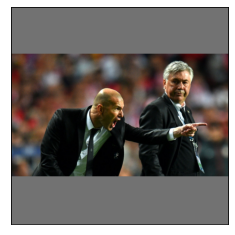

In [38]:
img_url, buffer = 'https://ultralytics.com/images/zidane.jpg', io.BytesIO()
curl = pycurl.Curl()
curl.setopt(pycurl.URL, img_url)
curl.setopt(pycurl.WRITEDATA, buffer)
curl.setopt(pycurl.FOLLOWLOCATION, True)
curl.perform()
curl.close()

img = np.frombuffer(buffer.getvalue(), dtype=np.uint8)
img = cv2.imdecode(img, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = util.mksquare(img, size=(640, 640))

_, ax = plt.subplots()
ax.imshow(img)
ax.set_xticks([]); ax.set_yticks([])
plt.show()

In [59]:
yolov5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).eval()
yolov5_vanish_attack = YOLOv5VanishAttack(model=yolov5, conf_thres=0.15, iou_thres=0.8, alpha=0.002, eps=0.04, max_iter=100)

Using cache found in /home/msk/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-11-13 torch 1.10.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [63]:
x = torch.FloatTensor(img) / 255
x = x.permute(2, 0, 1).unsqueeze(0)
x_adv = yolov5_vanish_attack(x, verbose=True)

Done (in 11 steps): 100%|██████████| 100/100 [00:00<00:00, 584.39it/s]


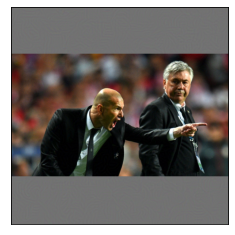

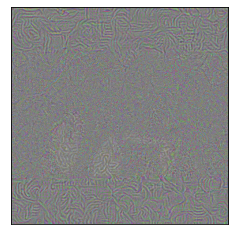

In [64]:
y_pred = yolov5(x_adv)[0]
y_pred = util.non_max_suppression(y_pred, 0.15, 0.5)[0]

fig, ax = plt.subplots()
ax.imshow(x_adv[0].detach().permute(1, 2, 0).cpu().numpy())
for i in range(len(y_pred)):
    x1, y1, x2, y2, confidence_score, label = y_pred[i].detach().cpu()
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, linewidth=3, edgecolor='y'))
    ax.text(x1, y1,
            f'{label:.0f} {confidence_score:.2f}',
            color='black', fontsize=12, backgroundcolor='y')

ax.set_xticks([]); ax.set_yticks([])
plt.show()

fig, ax = plt.subplots()
img_perturb = (x_adv.cpu() - x).squeeze().permute(1, 2, 0)
img_perturb = (img_perturb / yolov5_vanish_attack.eps).add(1).div(2).mul(255).byte()
ax.imshow(img_perturb)
ax.set_xticks([]); ax.set_yticks([])
plt.show()